In [68]:
#importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10


from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

In [69]:
#load the date to a pandas dataframe
df=pd.read_csv("data/Bitstamp_BTCUSD_d.csv")
df.head()

,Unix,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD;;;;;;;;
0,1660003200,2022-08-09 00:00:00,BTC/USD,23811.29,23836.69,23740.05,23785.56,5.982832,142305.019020144;;;;;;;;
1,1659916800,2022-08-08 00:00:00,BTC/USD,23177.72,24246.06,23169.64,23821.68,1845.040918,43951974.328593954;;;;;;;;
2,1659830400,2022-08-07 00:00:00,BTC/USD,22946.00,23411.55,22855.14,23187.62,691.383374,16031534.945992354;;;;;;;;
3,1659744000,2022-08-06 00:00:00,BTC/USD,23326.50,23354.54,22919.76,22956.61,672.145297,15430177.444037944;;;;;;;;
4,1659657600,2022-08-05 00:00:00,BTC/USD,22630.14,23478.00,22587.94,23326.40,2070.359898,48294043.12494047;;;;;;;;


Text(0, 0.5, 'Preço')

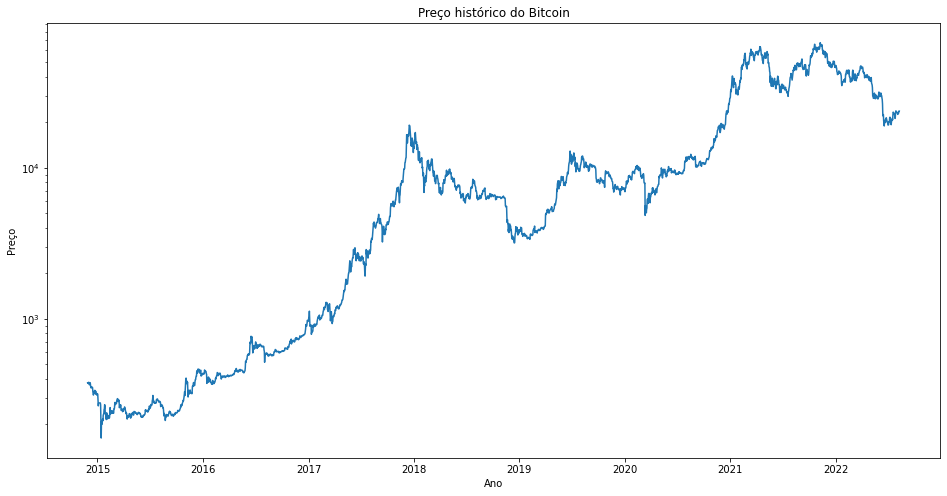

In [70]:
#format date column
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
#set date column as index
df.index=df['Date']
#plot figure
plt.figure(figsize=(16,8))
plt.plot(df["Close"])
plt.yscale("log")
plt.title("Preço histórico do Bitcoin")
plt.xlabel("Ano")
plt.ylabel("Preço")


In [71]:
#sort df ascending date
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

new_dataset

,Date,Close
0,2014-11-28 00:00:00,376.28
1,2014-11-29 00:00:00,376.72
2,2014-11-30 00:00:00,373.34
3,2014-12-01 00:00:00,378.39
4,2014-12-02 00:00:00,379.25
...,...,...
2807,2022-08-05 00:00:00,23326.4
2808,2022-08-06 00:00:00,22956.61
2809,2022-08-07 00:00:00,23187.62
2810,2022-08-08 00:00:00,23821.68


In [72]:
#get the close values as a vertical array ( add one more dimension to the array)
dataframe_close = new_dataset.Close.values
close_values=dataframe_close.reshape(-1,1)


In [73]:
#split the values in train and test
dataset_train = np.array(close_values[:int(close_values.shape[0]*0.8)])
dataset_test = np.array(close_values[int(close_values.shape[0]*0.8):])


In [74]:
#normalize the data 
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.fit_transform(dataset_test)
dataset_test.shape




(563, 1)

In [75]:
#create dataset with the last (timesteps) prices (x) as with the next price (y)
timesteps = 10
 
def create_dataset(df):
    x = []
    y = []
    for i in range(timesteps, df.shape[0]):
        x.append(df[i-timesteps:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [76]:
x_train, y_train = create_dataset(dataset_train)
x_test, y_test = create_dataset(dataset_test)

x_test.shape

(553, 10)

In [77]:
#create a 3D array to use in LTSM layer
#Tensors are the data structure used by machine learning systems, and getting to know them is an essential skill you should build early on.
#LTSM receive 3D tensor

#A tensor is a container for numerical data. It is the way we store the information that we’ll use within our system. [samples, time steps, features]
#The batch size is the size of the training batch you use. It can be anything and doesn't effect the size of the LSTM layer. It just modifies the gradient update step.

#Time steps is the one that determines the size, because it's the number of times that you unroll your LSTM cell. So, that is right, total number of unrolled cells is equal to 5.

#The features is related to the series you want to input/predict. If it is 1, the series is univariate, otherwise it is multi-variate and doesn't have anything to do with the number of cells unrolled.


x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_train.shape[1]

10

In [78]:
#variables for test
units = 96
dropout = 0.2
#create the sequence model
model = Sequential()
#we initialized our model as a sequential one with 96 units in the output’s dimensionality. We used return_sequences=True to make the LSTM layer with three-dimensional input and input_shape to shape our dataset.
#inputs: A 3D tensor with shape [batch, timesteps, feature]
# units : dimensionality of the output space 
#return sequences : Whether to return the last output. in the output sequence, or the full sequence. Default: False .This allows us to have 3D output from hidden LSTM layer as input to the next.
#stateful:  If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch.
#input_shape = [n_steps,n_features]
model.add(LSTM(units=units, return_sequences=True, input_shape=(x_train.shape[1], 1)))
#The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
#  Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged. Making the dropout fraction 0.2 drops 20% of the layers
model.add(Dropout(dropout))
model.add(LSTM(units=units,return_sequences=True))
model.add(Dropout(dropout))
model.add(LSTM(units=units,return_sequences=True))
model.add(Dropout(dropout))
model.add(LSTM(units=units))
model.add(Dropout(dropout))
#Finally, we added a dense layer with a value of 1 because we want to output one value.
model.add(Dense(units=1))
model.summary()
#num_params = g × [h(h+i) + h]
#g, no. of FFNNs in a unit (RNN has 1, GRU has 3, LSTM has 4)
#h, size of hidden units (units)
#i, dimension/size of input 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 10, 96)            37632     
                                                                 
 dropout_8 (Dropout)         (None, 10, 96)            0         
                                                                 
 lstm_9 (LSTM)               (None, 10, 96)            74112     
                                                                 
 dropout_9 (Dropout)         (None, 10, 96)            0         
                                                                 
 lstm_10 (LSTM)              (None, 10, 96)            74112     
                                                                 
 dropout_10 (Dropout)        (None, 10, 96)            0         
                                                                 
 lstm_11 (LSTM)              (None, 96)               

In [86]:
#We used loss='mean_squared_error' because it is a regression problem, and the adam optimizer to update network weights iteratively based on training data.
#The purpose of loss functions is to compute the quantity that a model should seek to minimize during training.
model.compile(loss='mean_absolute_error', optimizer='adam')

In [87]:
#epochs: Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
#batch_size: Number of samples per gradient update.
model.fit(x_train, y_train, epochs=12, batch_size=32)
model.save('stock_prediction.h5')

Epoch 1/12
70/70 [==============================] - 7s 20ms/step - loss: 0.0176
Epoch 2/12
70/70 [==============================] - 1s 20ms/step - loss: 0.0152
Epoch 3/12
70/70 [==============================] - 1s 21ms/step - loss: 0.0142
Epoch 4/12
70/70 [==============================] - 1s 20ms/step - loss: 0.0144
Epoch 5/12
70/70 [==============================] - 1s 20ms/step - loss: 0.0133
Epoch 6/12
70/70 [==============================] - 2s 23ms/step - loss: 0.0143
Epoch 7/12
70/70 [==============================] - 1s 20ms/step - loss: 0.0130
Epoch 8/12
70/70 [==============================] - 1s 18ms/step - loss: 0.0133
Epoch 9/12
70/70 [==============================] - 2s 26ms/step - loss: 0.0125
Epoch 10/12
70/70 [==============================] - 2s 22ms/step - loss: 0.0121
Epoch 11/12
70/70 [==============================] - 2s 31ms/step - loss: 0.0128
Epoch 12/12
70/70 [==============================] - 1s 19ms/step - loss: 0.0123


In [81]:
model.get_config()["layers"][1]["config"]

{'name': 'lstm_8',
 'trainable': True,
 'batch_input_shape': (None, 10, 1),
 'dtype': 'float32',
 'return_sequences': True,
 'return_state': False,
 'go_backwards': False,
 'stateful': False,
 'unroll': False,
 'time_major': False,
 'units': 96,
 'activation': 'tanh',
 'recurrent_activation': 'sigmoid',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'recurrent_initializer': {'class_name': 'Orthogonal',
  'config': {'gain': 1.0, 'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'unit_forget_bias': True,
 'kernel_regularizer': None,
 'recurrent_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'recurrent_constraint': None,
 'bias_constraint': None,
 'dropout': 0.0,
 'recurrent_dropout': 0.0,
 'implementation': 2}

In [88]:

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
len(predictions[0])

1

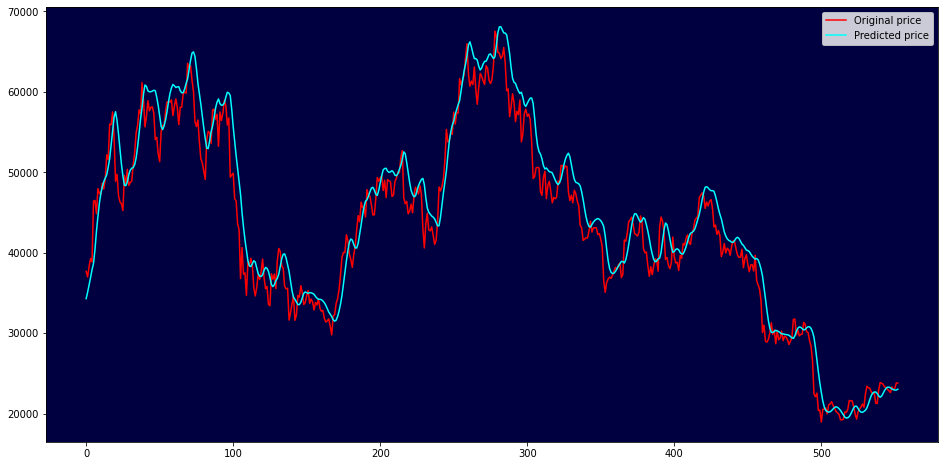

In [89]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor('#000041')
ax.plot(y_test_scaled, color='red', label='Original price')
plt.plot(predictions, color='cyan', label='Predicted price')
plt.legend()

In [96]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
#calculation of the error metrics in predictions
mae = mae(y_test_scaled,predictions)
mape = mape(y_test_scaled,predictions)
mse = mse(y_test_scaled,predictions)
print(mae,mape,mse)

2222.317200638562 0.053185040747473475 8545122.170487741
